In [1]:
import yaml
import pandas as pd

with open("../configs/default.yaml", 'r', encoding="utf-8") as f:
    config = yaml.safe_load(f)
    train_path = config["data"]["train_path"]
    df = pd.read_csv(train_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10343 entries, 0 to 10342
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMILES   10343 non-null  object 
 1   id       7973 non-null   float64
 2   Tg       557 non-null    float64
 3   FFV      7892 non-null   float64
 4   Tc       866 non-null    float64
 5   Density  613 non-null    float64
 6   Rg       614 non-null    float64
dtypes: float64(6), object(1)
memory usage: 565.8+ KB


In [26]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from myutility import featuring

# tqdm이 pandas의 apply와 함께 작동하도록 설정
tqdm.pandas()

# Tg 값이 없는 행(NaN)은 분석에서 제외
df_clean = df[['SMILES', 'Tg']].dropna().copy()

# 데이터프레임의 모든 SMILES에 함수를 적용하여 피처 생성
print("피처를 생성하는 중입니다...")
feature_data = df_clean['SMILES'].progress_apply(featuring.smiles_to_features)

# 리스트를 데이터프레임으로 변환
feature_df = pd.DataFrame(feature_data.tolist(), index=df_clean.index)

# 원본 데이터프레임과 피처 데이터프레임 합치기
final_df = pd.concat([df_clean, feature_df], axis=1)
final_df = final_df.dropna() # 피처 생성 실패한 경우 대비

피처를 생성하는 중입니다...


100%|██████████| 557/557 [00:00<00:00, 726.79it/s]

<class 'pandas.core.series.Series'>



Random Forest 모델을 학습하는 중입니다...
피처 중요도를 시각화하는 중입니다...


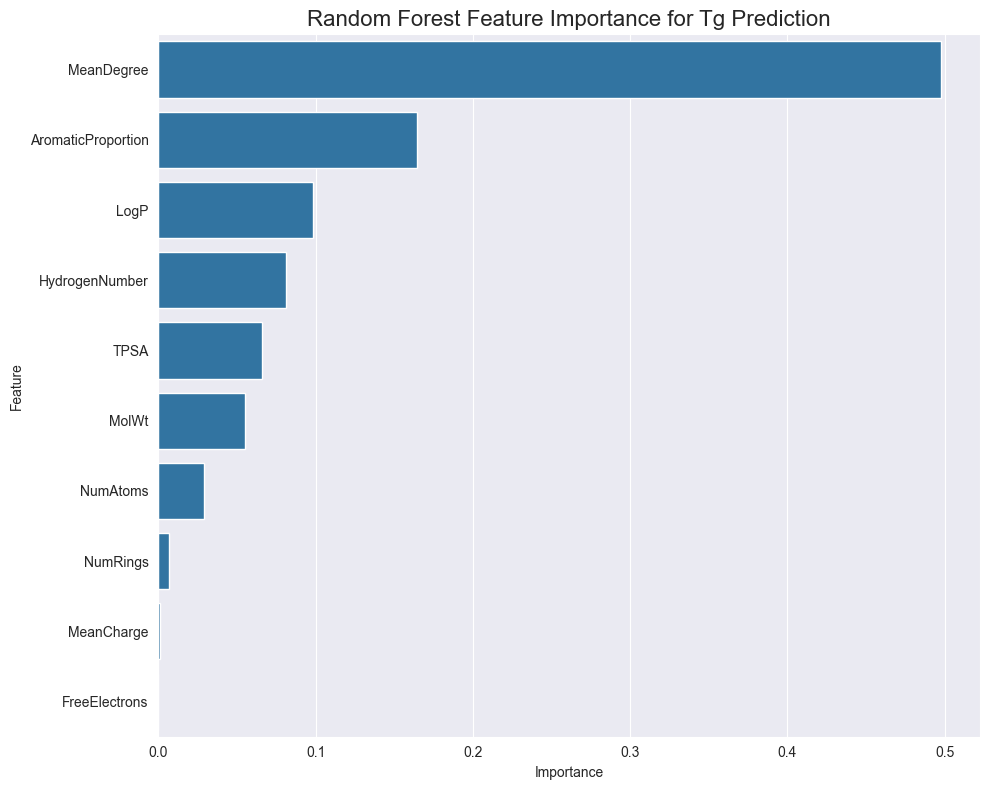

In [24]:
# --- 3. 모델 학습 및 피처 중요도 분석 ---
X = final_df[feature_df.columns]
y = final_df['Tg']

# Random Forest 모델 초기화 및 학습
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nRandom Forest 모델을 학습하는 중입니다...")
model.fit(X, y)

# 피처 중요도 추출
importances = model.feature_importances_
feature_names = X.columns

# 중요도를 데이터프레임으로 만들어 정렬
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# --- 4. 결과 시각화 ---
print("피처 중요도를 시각화하는 중입니다...")
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Random Forest Feature Importance for Tg Prediction', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

--- 중요도 상위 7개 피처 ---
['MeanDegree', 'AromaticProportion', 'LogP', 'HydrogenNumber', 'TPSA', 'MolWt', 'NumAtoms']


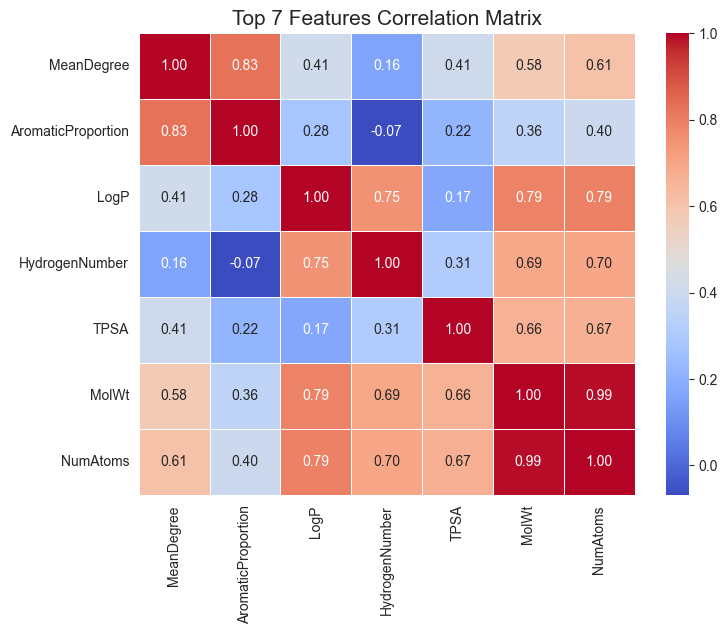

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# 이전 단계에서 생성된 'importance_df'와 피처 데이터프레임 'X'가 있다고 가정
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# X = final_df[feature_df.columns]

# --- 1. 중요도 기반으로 상위 7개 피처 선택 ---
K = 7
top_k_features = importance_df.head(K)['Feature'].tolist()
X_top_k = X[top_k_features]

print(f"--- 중요도 상위 {K}개 피처 ---")
print(top_k_features)

# --- 2. 상관관계 행렬 계산 및 히트맵 시각화 ---
# 상관계수 행렬 계산
corr_matrix = X_top_k.corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Top {K} Features Correlation Matrix', fontsize=15)
plt.show()